In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.


#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [9]:
# 고정적 seed 42로 고정.
import os
import random
import numpy as np
import tensorflow as tf
import logging


SEED =42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def set_global_determinism(seed=SEED, fast_n_close=False):
    """
        Enable 100% reproducibility on operations related to tensor and randomness.
        Parameters:
        seed (int): seed value for global randomness
        fast_n_close (bool): whether to achieve efficient at the cost of determinism/reproducibility
    """
    set_seeds(seed=seed)
    if fast_n_close:
        return

    logging.warning("*******************************************************************************")
    logging.warning("*** set_global_determinism is called,setting full determinism, will be slow ***")
    logging.warning("*******************************************************************************")

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    # https://www.tensorflow.org/api_docs/python/tf/config/threading/set_inter_op_parallelism_threads
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
#     from tfdeterminism import patch
#     patch()    
    
set_seeds(42)
set_global_determinism(42)

In [10]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM, BatchNormalization
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
import kerastuner as kt
import IPython

from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
import IPython


import matplotlib.pyplot as plt

ModuleNotFoundError: ignored

In [11]:
#우선 교차검증 시 데이터 분할이 어떻게 이루어지는지 그려 볼 수 있게 해주는 helper function을 가져오자.
from sklearn.model_selection import TimeSeriesSplit 
from matplotlib.patches import Patch
import matplotlib.pyplot as plt 

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')


def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

# 데이터 설명
* TurbID - 발전기 ID
* Day - 날짜
* Tmstamp - 시간
* Wspd - 풍속
* Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이
* Etmp - 외부 온도
* Itmp - 터빈 내부 온도
* Ndir - 터빈이 바라보는 방향 각도
* Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름
* Prtv - 무효전력 : 에너지원을 필요로  하지 않는 전력
* Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력 <br><br>

* <b>label: Patv </b>
# 결론적으로 134개 터빈의 201~202일, 즉 2일간의 Patv값을 예측해야 합니다.


# EDA
<font color=red>
1. Tmstamp를 hour, minute으로 변환 <br>
2. hour, Day, TurbID, minute순으로 재정렬 후 interpolate해서 결측치 처리 <br>

</font>

In [12]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [13]:
# 수정
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

FileNotFoundError: ignored

In [ ]:
df_updated = train_data.copy()

NameError: ignored

In [ ]:
df_updated

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,23:10,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01
4283708,134,222,23:20,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71
4283709,134,222,23:30,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63
4283710,134,222,23:40,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92


In [ ]:
df = df_updated[['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']].copy()
df.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


# Timestamp 변환 (시간, 분)으로 변경
* hour, minute로 변환

In [ ]:
df['Tmstamp'][0].split(':')

['00', '00']

In [ ]:
a, b = df['Tmstamp'][20].split(':')
a, b

('03', '20')

In [ ]:
print(int(a))

3


In [ ]:
def make_hour(values):
    a, b = values.split(':')
    
    return int(a)

df['hour'] = df['Tmstamp'].apply(lambda x: make_hour(x))   

In [ ]:
def make_minute(values):
    a, b = values.split(':')
    if b == '00':
        return 0
    elif b== '10':
        return 1
    elif b== '20':
        return 2
    elif b== '30':
        return 3
    elif b== '40':
        return 4
    elif b== '50':
        return 5

df['minute'] = df['Tmstamp'].apply(lambda x: make_minute(x))

In [ ]:
# 순서 넘겨주기.
df = df[['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]

In [ ]:
df.head()

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,0,1,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,0,2,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,0,3,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,0,4,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [ ]:
train_data = df.copy()
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,23:10,23,1,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01
4283708,134,222,23:20,23,2,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71
4283709,134,222,23:30,23,3,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63
4283710,134,222,23:40,23,4,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92


In [ ]:
# Feature 중 Tmstamp 정수로 변환
tms_list = list(pd.unique(train_data["Tmstamp"]))

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x))

In [ ]:
train_data[143:160]

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
143,1,1,143,23,5,9.95,-0.42,28.31,42.09,-8.17,1.01,1.01,1.01,-0.20,1361.95
144,1,2,0,0,0,10.64,-1.59,28.10,42.17,-9.66,1.01,1.01,1.01,-0.27,1468.21
145,1,2,1,0,1,7.00,0.84,27.87,42.05,-2.77,1.00,1.00,1.00,-0.16,718.12
146,1,2,2,0,2,5.87,-2.61,27.38,41.73,-9.17,0.99,0.99,0.99,-0.27,442.15
147,1,2,3,0,3,4.00,3.26,27.13,41.76,-8.20,0.99,0.99,0.99,-0.21,196.04
148,1,2,4,0,4,4.03,2.88,26.99,41.66,2.82,0.99,0.99,0.99,-0.23,234.35
149,1,2,5,0,5,3.46,1.32,26.80,41.36,38.08,0.99,0.99,0.99,-0.23,124.94
150,1,2,6,1,0,3.96,-0.03,26.52,40.87,22.25,0.99,0.99,0.99,-0.24,179.06
151,1,2,7,1,1,4.63,-2.50,26.25,39.97,38.62,0.99,0.99,0.99,-0.24,253.25
152,1,2,8,1,2,5.40,-0.77,26.01,39.09,46.95,0.99,0.99,0.99,-0.25,347.00


# hour, Day, TurbID, minute 순으로 재정렬.
* 이유는 hour과 Wspd의 관계를 봤을 때,
* 제시한 바와같이 정렬하게 될 시에, hour, Day, TurbID, minute 순으로 정렬이 된다.
* Wspd는 같은 hour이어야하기 때문에 hour이 먼저, 그 다음에 다른 TurbID의 값을 interpolate해줘야하기 때문에 Day, 그 다음 TurbID, minute 순으로 정렬

In [ ]:
df = train_data.copy()

In [ ]:
df = df.sort_values(by=['hour', 'Day', 'TurbID', 'minute'])
df.reset_index(drop=True, inplace=True)
df

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,139,23,1,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01
4283708,134,222,140,23,2,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71
4283709,134,222,141,23,3,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63
4283710,134,222,142,23,4,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92


In [ ]:
df = df.interpolate()
df = df.fillna(method='bfill')

In [ ]:
df.isnull().sum()

TurbID     0
Day        0
Tmstamp    0
hour       0
minute     0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64

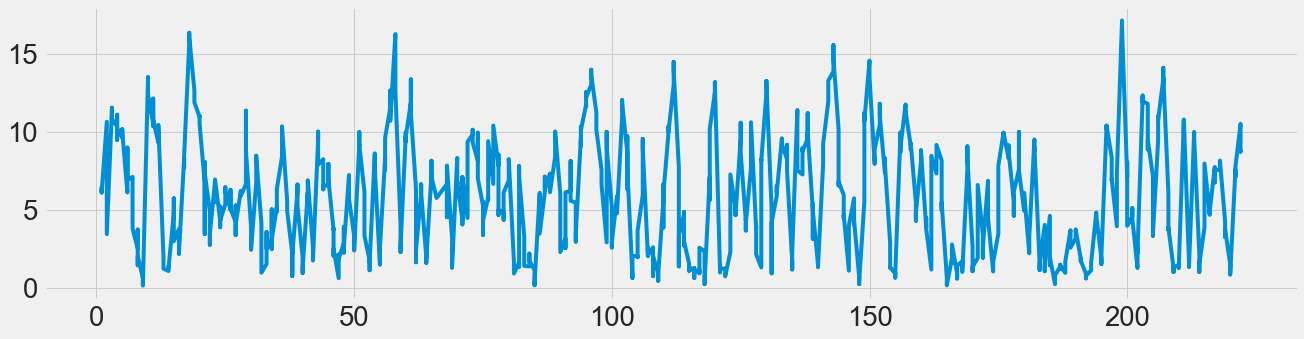

In [ ]:
# Tmstamp 당 Patv 추세를 확인.
plt.figure(figsize=(20, 5))
#j = 201 # Day
j = 0 # hour
for i in range(1, 2): # TurbID / group 6
    plt.plot(df[(df['TurbID']==i) & (df['hour']==j)]['Day'], df[(df['TurbID']==i) & (df['hour']==j)]['Wspd'])
    #plt.plot(train_data[(train_data['TurbID']==i)]['Day'], train_data[(train_data['TurbID']==i)]['Patv'])
    #plt.xticks([])
# k = 21 # turb id
# plt.plot(df1[(df1['TurbID']==k) & (df1['Day']==j)]['Tmstamp'], df1[(df1['TurbID']==k) & (df1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')

In [ ]:
train_data = df.copy()
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,139,23,1,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01
4283708,134,222,140,23,2,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71
4283709,134,222,141,23,3,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63
4283710,134,222,142,23,4,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92


# 정렬한 것 원래대로 만들기.

In [ ]:
train_data = train_data.sort_values(by=['TurbID', 'Day', 'hour', 'minute'])
train_data.reset_index(drop=True, inplace=True)
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,139,23,1,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01
4283708,134,222,140,23,2,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71
4283709,134,222,141,23,3,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63
4283710,134,222,142,23,4,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92


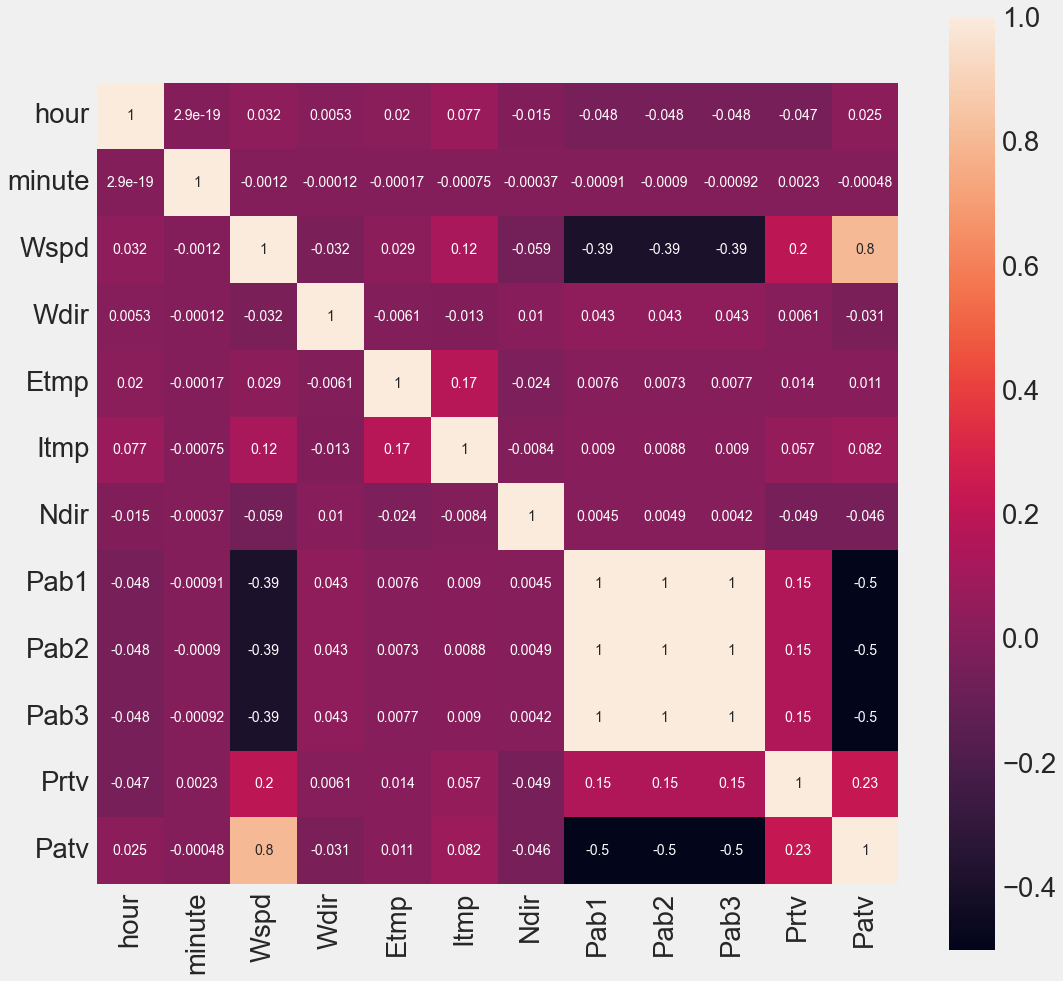

In [ ]:
plt.subplots(figsize=(16, 16))
sns.heatmap(train_data[['hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']].corr(), annot=True, square=True)
plt.show()

In [ ]:
train_data.columns

Index(['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp',
       'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv'],
      dtype='object')

In [ ]:
train_data.isnull().sum()

TurbID     0
Day        0
Tmstamp    0
hour       0
minute     0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64

In [ ]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,139,23,1,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01
4283708,134,222,140,23,2,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71
4283709,134,222,141,23,3,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63
4283710,134,222,142,23,4,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92


In [ ]:
# c.reset_index(drop=True, inplace=True)
# c

In [ ]:
# print(RMSE_MAE(c['Itmp'], c['comparison']))

In [ ]:
plt.subplots(figsize=(16, 16))
sns.heatmap(train_data.corr(), annot=True, square=True)
plt.show()

In [ ]:
train_data

# train_set 만들기

In [ ]:
def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        # 수정
        for j in range(1, 217): # 200일까지 일때 195.
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Wspd"]
            
            # feature 선택 및 제거
            train_tmp = train_tmp[['Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y

In [ ]:
train_x, train_y = make_train_data(train_data)

100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:28<00:00,  4.71it/s]


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

#GPU 자원이 부족한 경우 아래 코드를 이용하세요
'''from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)'''

'from tensorflow.compat.v1 import ConfigProto\nfrom tensorflow.compat.v1 import InteractiveSession\n\nconfig = ConfigProto()\nconfig.gpu_options.allow_growth = True\nsession = InteractiveSession(config=config)'

In [ ]:
train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
train_y = np.array(train_y)

In [ ]:
train_x.shape, train_y.shape

((28944, 720, 13), (28944, 288))

In [ ]:
train_x[0].shape[0]

720

# 모델 학습
* 모델 저장과 복원: https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ko
* 딥러닝 tensorflow에서 학습된 모델 저장 및 불러오기: https://minimin2.tistory.com/105


In [ ]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from keras.layers import Embedding, TimeDistributed
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM, BatchNormalization
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
import kerastuner as kt
import IPython

from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
import IPython


import matplotlib.pyplot as plt

In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
    
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
train_x[0].shape[0], train_x[0].shape[1]

(720, 13)

In [ ]:
from keras import backend as K

def RMSE_MAE(y_true, y_pred):
    mse1 = K.mean(K.square((y_true - y_pred)))
    mae1 = K.mean(K.abs((y_true - y_pred)))
    
    return (K.sqrt(mse1) + mae1) / 2

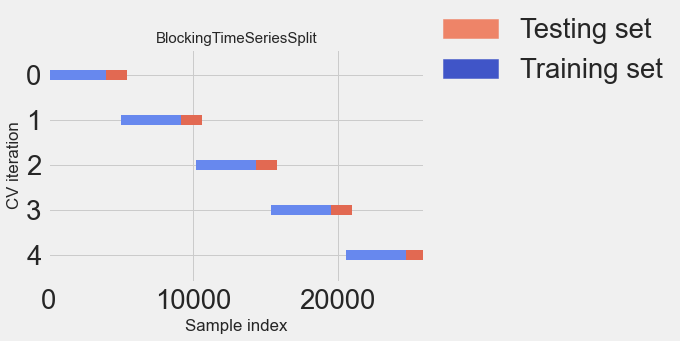

In [ ]:
XX = np.arange(25996)
n_split = 5
btscv = BlockingTimeSeriesSplit(n_splits=n_split)
plot_cv_indices(btscv, XX, n_splits=n_split)

In [ ]:
# # 25996 = 터빈 X Day (test: 134*2 = 268)


# n_split = 5

# tscv = TimeSeriesSplit(n_splits=n_split)

# plot_cv_indices(tscv, XX, n_splits=n_split)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

EPOCH=9
BATCH_SIZE=128

filename = 'checkpoint_wspd/checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(EPOCH, BATCH_SIZE)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

# 간단한 Sequential 모델을 정의합니다
def create_model():
    for i, (train_index, test_index) in enumerate(btscv.split(train_x)):
        print("cv:", i+1, "TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = train_x[train_index], train_x[test_index]
        y_train, y_test = train_y[train_index], train_y[test_index]
        
        model = Sequential()
        model.add(LSTM(512, input_shape=(train_x[0].shape[0], train_x[0].shape[1]))) # n X 512
        model.add(Dense(512, activation='relu'))
        model.add(Dense(288, activation = 'relu'))
    
        optimizer = tf.optimizers.RMSprop(0.001)
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
        
        model.compile(optimizer=optimizer, loss='mse', metrics=[RMSE_MAE])
        
        
        
        model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), callbacks=[es, checkpoint])
    return model

In [ ]:
model = create_model()

cv: 1 TRAIN: [   0    1    2 ... 4627 4628 4629] TEST: [4630 4631 4632 ... 5785 5786 5787]
Epoch 1/9
36/37 [============================>.] - ETA: 0s - loss: 14.0124 - RMSE_MAE: 3.3159
Epoch 1: val_loss improved from inf to 12.89460, saving model to checkpoint_wspd\checkpoint-epoch-9-batch-128-trial-001.h5
37/37 [==============================] - 10s 102ms/step - loss: 14.0001 - RMSE_MAE: 3.3082 - val_loss: 12.8946 - val_RMSE_MAE: 3.1965
Epoch 2/9
36/37 [============================>.] - ETA: 0s - loss: 11.5424 - RMSE_MAE: 3.0452
Epoch 2: val_loss improved from 12.89460 to 12.43744, saving model to checkpoint_wspd\checkpoint-epoch-9-batch-128-trial-001.h5
37/37 [==============================] - 3s 74ms/step - loss: 11.5623 - RMSE_MAE: 3.0556 - val_loss: 12.4374 - val_RMSE_MAE: 3.1613
Epoch 3/9
36/37 [============================>.] - ETA: 0s - loss: 11.0108 - RMSE_MAE: 2.9730
Epoch 3: val_loss improved from 12.43744 to 12.39803, saving model to checkpoint_wspd\checkpoint-epoch-9-batch

37/37 [==============================] - 3s 73ms/step - loss: 7.8791 - RMSE_MAE: 2.4955 - val_loss: 8.3368 - val_RMSE_MAE: 2.5982
Epoch 9/9
36/37 [============================>.] - ETA: 0s - loss: 7.6972 - RMSE_MAE: 2.4649
Epoch 9: val_loss improved from 8.33678 to 8.04212, saving model to checkpoint_wspd\checkpoint-epoch-9-batch-128-trial-001.h5
37/37 [==============================] - 3s 77ms/step - loss: 7.6943 - RMSE_MAE: 2.4622 - val_loss: 8.0421 - val_RMSE_MAE: 2.5696
cv: 4 TRAIN: [17364 17365 17366 ... 21991 21992 21993] TEST: [21994 21995 21996 ... 23149 23150 23151]
Epoch 1/9
36/37 [============================>.] - ETA: 0s - loss: 12.3938 - RMSE_MAE: 3.1050
Epoch 1: val_loss did not improve from 8.04212
37/37 [==============================] - 4s 80ms/step - loss: 12.3824 - RMSE_MAE: 3.0954 - val_loss: 10.2150 - val_RMSE_MAE: 2.7698
Epoch 2/9
36/37 [============================>.] - ETA: 0s - loss: 10.4092 - RMSE_MAE: 2.8682
Epoch 2: val_loss did not improve from 8.04212
37/3

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 512)               1077248   
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 dense_9 (Dense)             (None, 288)               147744    
                                                                 
Total params: 1,487,648
Trainable params: 1,487,648
Non-trainable params: 0
_________________________________________________________________


# 223일, 224일 전체 점수 (RMSE)

In [ ]:
# 수정
test_data_list1 = [x for x in range(218, 223)]

test_data1 = train_data[train_data["Day"].isin(test_data_list1)]

# test_data = test_data[test_data['TurbID']==102]

test_data1 = test_data1[['Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]

test_data1 = np.array(test_data1).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])

In [ ]:
test_data1.shape

(134, 720, 13)

In [ ]:
pred1 = model.predict(test_data1)
pred1 = pred1.reshape(-1)

In [ ]:
sadfasdf

In [ ]:
sample_submission['Wspd'] = pred1

In [ ]:
sample_submission

In [ ]:
# sample_submission.to_csv('submission/0717_LSTM_Itmp_cv_test_17_4.csv')

# 한가지 풍속

In [ ]:
# 수정
test_data_list = [x for x in range(218, 223)]

test_data = train_data[train_data["Day"].isin(test_data_list)]

test_data = test_data[test_data['TurbID']==75]

test_data = test_data[['Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])

pred = model.predict(test_data)
pred = pred.reshape(-1)

b = []
for l in range(134):
    b += list(pred)

In [ ]:
sample_submission['Wspd'] = b
sample_submission['Wspd']

0        2.330775
1        2.658378
2        2.708983
3        1.919631
4        1.356009
           ...   
38587    2.111769
38588    2.450005
38589    2.464705
38590    2.224988
38591    2.817423
Name: Wspd, Length: 38592, dtype: float32

In [ ]:
sample_submission

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,223,00:00,2.330775,0,0,0,0,0,0,0,0,0
1,1,1,223,00:10,2.658378,0,0,0,0,0,0,0,0,0
2,2,1,223,00:20,2.708983,0,0,0,0,0,0,0,0,0
3,3,1,223,00:30,1.919631,0,0,0,0,0,0,0,0,0
4,4,1,223,00:40,1.356009,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,38587,134,224,23:10,2.111769,0,0,0,0,0,0,0,0,0
38588,38588,134,224,23:20,2.450005,0,0,0,0,0,0,0,0,0
38589,38589,134,224,23:30,2.464705,0,0,0,0,0,0,0,0,0
38590,38590,134,224,23:40,2.224988,0,0,0,0,0,0,0,0,0


In [ ]:
sample_submission.to_csv('submission/0729_LSTM_Wspd_cv_test_75.csv')

# Predicted Wspd

In [ ]:
df = sample_submission.copy()
df

In [ ]:
# Feature 중 Tmstamp 정수로 변환
tms_list = list(pd.unique(df["Tmstamp"]))

df["Tmstamp"] = df["Tmstamp"].apply(lambda x : tms_list.index(x))

In [ ]:
df['predicted_Wspd'] = pred1

# 200일 풍속

In [ ]:
# Tmstamp 당 Patv 추세를 확인.
plt.figure(figsize=(20, 5))
#j = 201 # Day
j = 222 # Day
for i in range(1, 134): # TurbID / group 6
    plt.plot(train_data[(train_data['TurbID']==i) & (train_data['Day']==j)]['Tmstamp'], train_data[(train_data['TurbID']==i) & (train_data['Day']==j)]['Wspd'])
    #plt.plot(train_data[(train_data['TurbID']==i)]['Day'], train_data[(train_data['TurbID']==i)]['Patv'])
    #plt.xticks([])
# k = 21 # turb id
# plt.plot(df1[(df1['TurbID']==k) & (df1['Day']==j)]['Tmstamp'], df1[(df1['TurbID']==k) & (df1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')

In [ ]:
# Tmstamp 당 Patv 추세를 확인.
plt.figure(figsize=(20, 5))
j = 223 # Day

for i in range(1, 135): # TurbID / group 6
    plt.plot(df[(df['TurbID']==i) & (df['Day']==j)]['Tmstamp'], df[(df['TurbID']==i) & (df['Day']==j)]['predicted_Wspd'])
    #plt.plot(train_data[(train_data['TurbID']==i)]['Day'], train_data[(train_data['TurbID']==i)]['Patv'])
    #plt.xticks([])
plt.plot(df[(df['TurbID']==75) & (df['Day']==j)]['Tmstamp'], df[(df['TurbID']==75) & (df['Day']==j)]['predicted_Wspd'], linewidth=10.0)
# plt.plot(df1[(df1['TurbID']==k) & (df1['Day']==j)]['Tmstamp'], df1[(df1['TurbID']==k) & (df1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')

In [ ]:
# Tmstamp 당 Patv 추세를 확인.
plt.figure(figsize=(20, 5))
j = 224 # Day

for i in range(1, 135): # TurbID / group 6
    plt.plot(df[(df['TurbID']==i) & (df['Day']==j)]['Tmstamp'], df[(df['TurbID']==i) & (df['Day']==j)]['predicted_Wspd'])
    #plt.plot(train_data[(train_data['TurbID']==i)]['Day'], train_data[(train_data['TurbID']==i)]['Patv'])
    #plt.xticks([])
plt.plot(df[(df['TurbID']==75) & (df['Day']==j)]['Tmstamp'], df[(df['TurbID']==75) & (df['Day']==j)]['predicted_Wspd'], linewidth=10.0)
# plt.plot(df1[(df1['TurbID']==k) & (df1['Day']==j)]['Tmstamp'], df1[(df1['TurbID']==k) & (df1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')